In [47]:
#@title import libraries
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import randint
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [48]:
#@title Download latest version of dataset
path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uciml/red-wine-quality-cortez-et-al-2009/versions/2


In [49]:
#@title Cargamos el dataset y mostramos las 5 primeras filas
data = pd.read_csv("/root/.cache/kagglehub/datasets/uciml/red-wine-quality-cortez-et-al-2009/versions/2/winequality-red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [50]:
#@title eliminar datos repetidos
data = data.drop_duplicates()

In [51]:
data.dtypes

,0
fixed acidity,float64
volatile acidity,float64
citric acid,float64
residual sugar,float64
chlorides,float64
free sulfur dioxide,float64
total sulfur dioxide,float64
density,float64
pH,float64
sulphates,float64


In [52]:
data.shape

(1359, 12)

In [53]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


(array([ 10.,   0.,  53.,   0., 577.,   0., 535.,   0., 167.,  17.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <BarContainer object of 10 artists>)

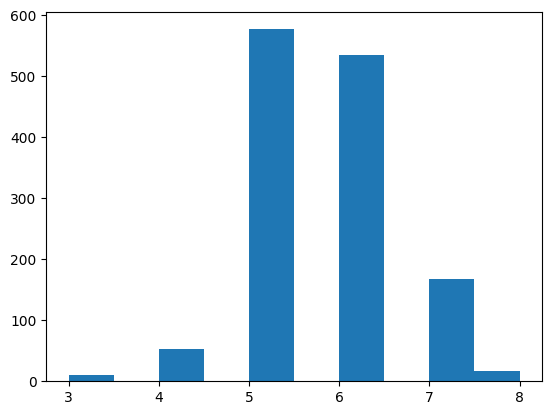

In [55]:
plt.hist(data.quality)

In [56]:
predictors_col = [
      "fixed acidity",
      "volatile acidity",
      "citric acid",
      "residual sugar",
      "chlorides",
      "density",
      "pH",
      "sulphates",
      "alcohol",
     ]
target_col = ['quality']
predictors = data[predictors_col]
target = data[target_col]

In [57]:
#@title Creamos nuevas variables para intentar predecir mejor la calidad
predictors_col.append('sulphates_alcohol_ratio')
predictors['sulphates_alcohol_ratio'] = predictors['sulphates'] / predictors['alcohol']
predictors_col.append('residual_sugar_alcohol_ratio')
predictors['residual_sugar_alcohol_ratio'] = predictors['residual sugar'] / predictors['alcohol']

<ipython-input-57-6861f7768d40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors['sulphates_alcohol_ratio'] = predictors['sulphates'] / predictors['alcohol']
<ipython-input-57-6861f7768d40>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors['residual_sugar_alcohol_ratio'] = predictors['residual sugar'] / predictors['alcohol']


(array([577.,   0., 577.,   0., 577.,   0., 577.,   0., 577., 577.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <BarContainer object of 10 artists>)

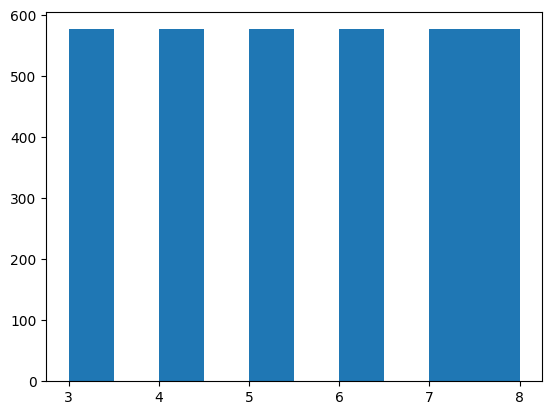

In [58]:
#@title SMOTE tecnique for balance queality
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(predictors, target)
# Convertir los resultados en un DataFrame de pandas nuevamente
df_resampled = pd.DataFrame(X_resampled, columns=predictors_col)
df_resampled['quality'] = y_resampled
plt.hist(df_resampled.quality)

In [59]:
predictors_col = [
      "fixed acidity",
      "volatile acidity",
      "citric acid",
      "residual sugar",
      "chlorides",
      "density",
      "pH",
      "sulphates",
      "alcohol",
      "sulphates_alcohol_ratio",
      "residual_sugar_alcohol_ratio",
     ]
predictors = df_resampled[predictors_col]
target = df_resampled[target_col]

<Axes: xlabel='sulphates_alcohol_ratio', ylabel='residual_sugar_alcohol_ratio'>

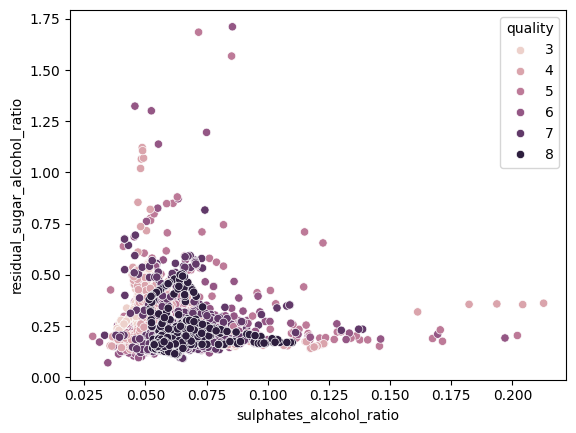

In [60]:
sns.scatterplot(x =  "sulphates_alcohol_ratio", y = "residual_sugar_alcohol_ratio", hue = "quality", data = df_resampled)

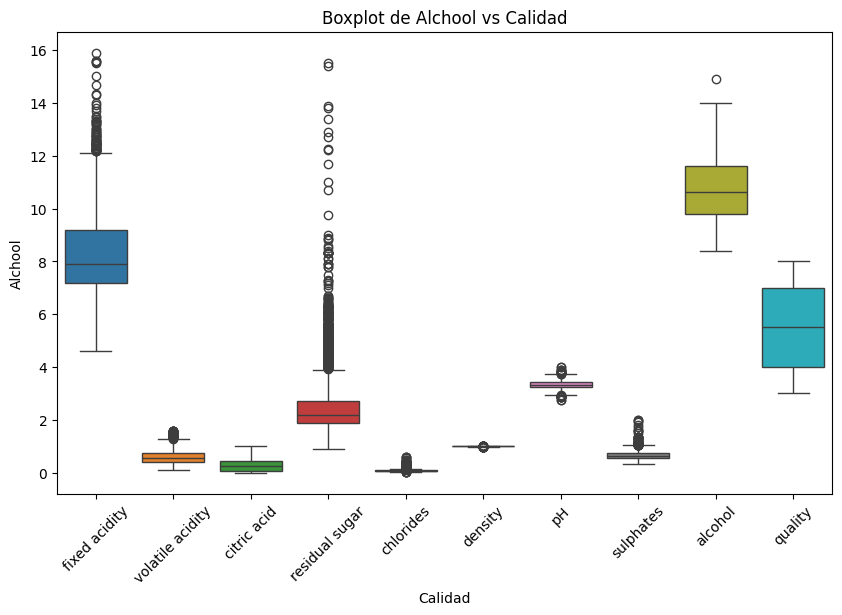

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_resampled[
    [
      "fixed acidity",
      "volatile acidity",
      "citric acid",
      "residual sugar",
      "chlorides",
      "density",
      "pH",
      "sulphates",
      "alcohol",
      "quality",
     ]
])
plt.xticks(rotation=45)
plt.title('Boxplot de Alchool vs Calidad')
plt.xlabel('Calidad')
plt.ylabel('Alchool')
plt.show()

In [62]:
corr = predictors.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,density,pH,sulphates,alcohol,sulphates_alcohol_ratio,residual_sugar_alcohol_ratio
fixed acidity,1.000000,-0.311727,0.720375,0.100064,0.110272,0.653759,-0.712637,0.213090,-0.132846,0.266443,0.111340
volatile acidity,-0.311727,1.000000,-0.662672,0.025787,0.177253,0.060462,0.478110,-0.499821,-0.247813,-0.375538,0.080573
citric acid,0.720375,-0.662672,1.000000,0.105363,0.100826,0.294399,-0.687519,0.452003,0.144505,0.385199,0.061205
residual sugar,0.100064,0.025787,0.105363,1.000000,-0.024742,0.287429,-0.040633,-0.060999,0.122710,-0.110985,0.970519
chlorides,0.110272,0.177253,0.100826,-0.024742,1.000000,0.241096,-0.166283,0.188951,-0.313829,0.361529,0.040068
density,0.653759,0.060462,0.294399,0.287429,0.241096,1.000000,-0.317866,0.003480,-0.599687,0.269495,0.404720
pH,-0.712637,0.478110,-0.687519,-0.040633,-0.166283,-0.317866,1.000000,-0.305342,0.145007,-0.369562,-0.057930
sulphates,0.213090,-0.499821,0.452003,-0.060999,0.188951,0.003480,-0.305342,1.000000,0.243929,0.893655,-0.109053
alcohol,-0.132846,-0.247813,0.144505,0.122710,-0.313829,-0.599687,0.145007,0.243929,1.000000,-0.208563,-0.090481
sulphates_alcohol_ratio,0.266443,-0.375538,0.385199,-0.110985,0.361529,0.269495,-0.369562,0.893655,-0.208563,1.000000,-0.062491


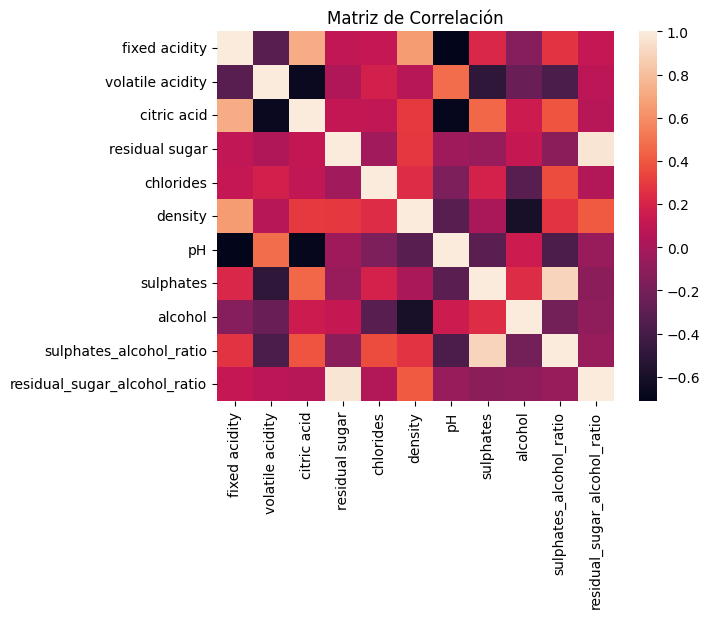

In [63]:
sns.heatmap(corr)
plt.title('Matriz de Correlación')
plt.show()

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuramos el rango de hiperparámetros para RandomizedSearchCV
param_dist = {
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy']
}

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, random_state=3)

# Configuramos el clasificador base
basic_tree = DecisionTreeClassifier(random_state=3)

# Configuramos RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=basic_tree,
    param_distributions=param_dist,
    n_iter=160,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    random_state=3
)

# Ajustamos RandomizedSearchCV
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Entrenamos el modelo final con los mejores hiperparámetros
tree_decision = DecisionTreeClassifier(**best_params, random_state=3)
tree_decision.fit(X_train, y_train)

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 9}


DecisionTreeClassifier(max_depth=23, min_samples_split=9, random_state=3)

In [88]:
predicciones = tree_decision.predict(X_test)
predicciones

array([6, 7, 8, ..., 7, 4, 4])

In [89]:
print("Accuracy:", accuracy_score(y_test, predicciones))
print("Precision:", precision_score(y_test, predicciones, average='weighted'))
print("Recall:", recall_score(y_test, predicciones, average='weighted'))
print("F1 Score:", f1_score(y_test, predicciones, average='weighted'))

Accuracy: 0.726660250240616
Precision: 0.7218478077151187
Recall: 0.726660250240616
F1 Score: 0.7232895523072266


In [90]:
pd.crosstab(np.array([y[0] for y in y_test.values.tolist()]), predicciones, rownames=['Actual'], colnames=['Predicciones'])

Predicciones,3,4,5,6,7,8
Actual,,,,,,
3,163,6,5,1,0,0
4,2,150,16,14,0,0
5,3,24,90,36,8,1
6,0,23,50,64,29,7
7,0,1,7,26,127,10
8,0,0,1,7,7,161


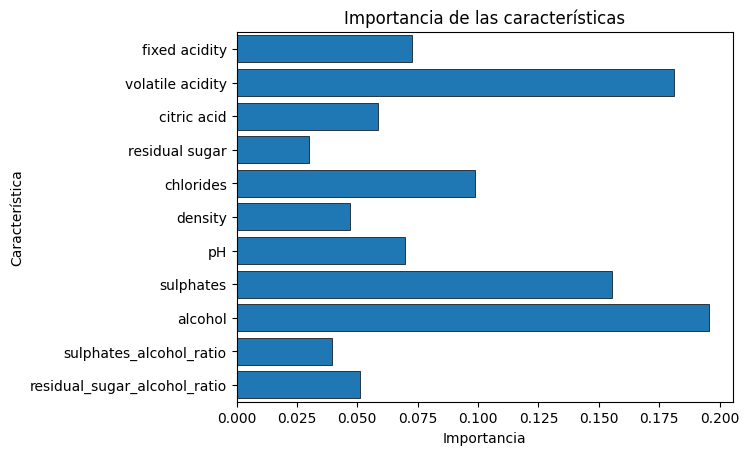

In [91]:
importances = tree_decision.feature_importances_
columns = predictors.columns
sns.barplot(x=importances, y=columns, saturation=2.0, edgecolor='black', linewidth=0.5)
plt.title('Importancia de las características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


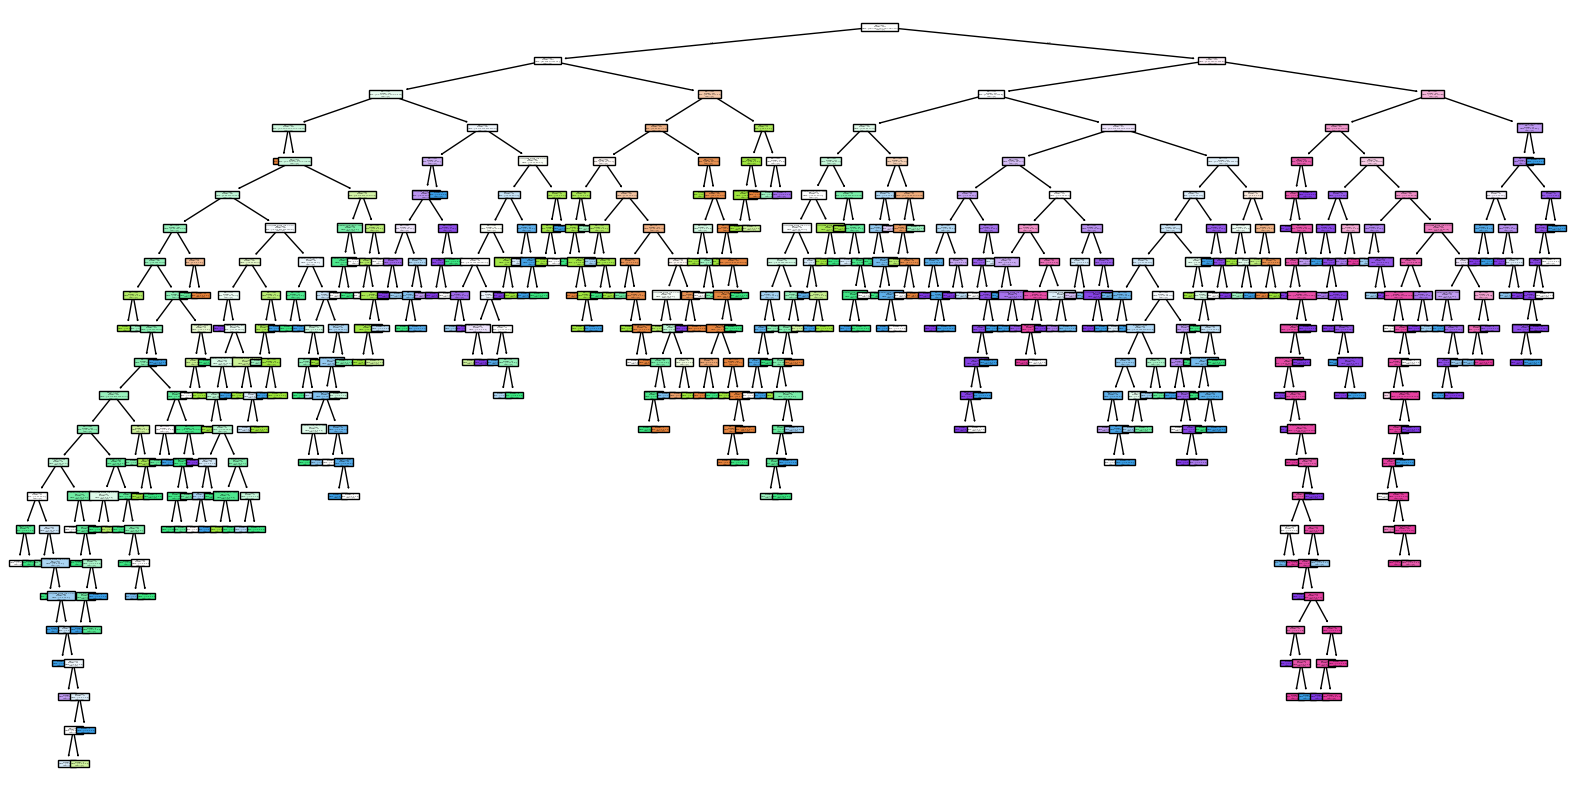

In [94]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(tree_decision, feature_names=predictors.columns, class_names=True, filled=True)
plt.show()


In [ ]:
"""
Como analisis del entrenamiento podemos ver que los datos iniciales estan poco equilibrados por lo que tuvimos que aplicar tecnicas de integración de datos,
además de esto pudimos encontrar variables ocultas como el sulphates_alchohol_ratio, y la residual_shugar_alcohol_ratio, que nos ayudo a mejorar la precisión del modelo.

Podemos tambien notar una relación entre el alcohol, el sulphates y la volatile acidity a la hora de influir en el entrenamiento.
"""

0.6323668598233996